In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sampleset import SampleSet
import os

import shutil
from collections import Counter
import numpy as np
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import argparse
from joblib import Parallel, delayed, parallel_backend
from sklearn.metrics import roc_curve, auc


def poisson_loss(logits,y_true):
    """
    Compute the Poisson negative log-likelihood loss.
    
    Args:
        y_true (torch.Tensor): True labels (0, 1, 2, ...), shape (batch_size,).
        logits (torch.Tensor): Output of the DNN (before exponentiation), shape (batch_size,).
    
    Returns:
        torch.Tensor: Mean negative log-likelihood loss over the batch.
    """
    # Convert logits to λ(x) = e^logits
    lambda_pred = torch.exp(logits)
    
    # Compute the negative log-likelihood
    loss = lambda_pred - y_true * logits  # Equivalent to λ(x) - Y * log(λ(x))
    return loss.mean()






class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.network(x)

# def train_network(network, train_loader,mode="Bernoulli", num_epochs=100, learning_rate=0.1,weight_decay=0.05):
#     if mode == "Bernoulli":
#         criterion = nn.BCEWithLogitsLoss() 
#     elif mode=="Poisson":
#         criterion=poisson_loss
#     else:
#     # Raise an error for unsupported modules
#         raise ValueError(f"Unsupported module type {mode}. Expected one of: 'Bernoulli', 'Gaussian', 'Exponential', 'Poisson'.")
    
#     # BCELossWithLogits combines sigmoid and binary cross-entropy in one function
     
#     optimizer = optim.SGD(network.parameters(), lr=learning_rate,weight_decay=weight_decay)

#     # Training loop
#     for epoch in range(num_epochs):
#         for batch_X, batch_Y in train_loader:
#             # Forward pass
#             logits = network(batch_X).squeeze() # Get scalar logits, shape (batch_size)
#             # print(torch.max(logits))  
#             loss = criterion(logits, batch_Y.float())  # Y needs to be float for BCELossWithLogits
            
#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         # Print loss every 10 epochs for tracking
#         if (epoch + 1) % 20 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


def train_network(network, train_loader,mode="Bernoulli", num_epochs=100, learning_rate=0.1,weight_decay=0.05,tol=0.00001,patience=7):
    if mode == "Bernoulli":
        criterion = nn.BCEWithLogitsLoss() 
    elif mode=="Poisson":
        criterion=poisson_loss
    else:
    # Raise an error for unsupported modules
        raise ValueError(f"Unsupported module type {mode}. Expected one of: 'Bernoulli', 'Gaussian', 'Exponential', 'Poisson'.")
    
    # BCELossWithLogits combines sigmoid and binary cross-entropy in one function
    length=len(train_loader.dataset)
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,weight_decay=weight_decay)
    prev_epoch_loss = None  
    stable_count=0 
    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0  
        for batch_X, batch_Y in train_loader:
            # Forward pass
            logits = network(batch_X).squeeze() # Get scalar logits, shape (batch_size)
            # print(torch.max(logits))  
            loss = criterion(logits, batch_Y.float())  # Y needs to be float for BCELossWithLogits
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_X.size(0)
    
    # Compute average loss for the epoch
        epoch_loss = running_loss / length
        # print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}")
        
        # Early‐stop check
        if prev_epoch_loss is not None:
            delta = abs(prev_epoch_loss - epoch_loss)
            if delta < tol:
                stable_count += 1
            else:
                stable_count = 0  # 重置计数

            if stable_count >= patience:
                print(f"Early stop at epoch {epoch} after {patience} stable epochs with loss {epoch_loss}.")
                break
        prev_epoch_loss = epoch_loss
    print(f"With loss {epoch_loss}.")

def train_single_model(X_sub, Y_sub, X_test, p, mode, num_epochs, batchsize, learning_rate, weight_decay):
    dataset = TensorDataset(X_sub, Y_sub)
    loader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

    network = BinaryClassifier(p)
    train_network(network, loader, mode=mode,
                  num_epochs=num_epochs, learning_rate=learning_rate,
                  weight_decay=weight_decay)

    preds = network(X_test).squeeze(1).detach().cpu()
    return preds

def train_and_predict_NN_parallel(sample_set, X_test, mode="Bernoulli", batchsize=64,
                                  num_epochs=500, learning_rate=0.1, weight_decay=0.02,
                                  n_jobs=20):
    train_samples = sample_set.subtrain
    ntest = X_test.shape[0]
    n = sample_set.n
    r = sample_set.r
    counts = sample_set.counts
    B = len(train_samples)

    # Compute inclusion proportions
    J_dot = {i: counts[i] / B for i in range(n)}

    # Prepare args for parallel
    args_list = [
        (X_sub, Y_sub, X_test, sample_set.p, mode, num_epochs, batchsize, learning_rate, weight_decay)
        for (X_sub, Y_sub, _) in train_samples
    ]

    # Parallel execution
    all_preds = Parallel(n_jobs=n_jobs)(
        delayed(train_single_model)(*args) for args in args_list
    )

    # Stack predictions: shape (ntest, B)
    all_out = torch.stack(all_preds, dim=1)

    # Ensemble mean prediction
    hatf_B = all_out.mean(dim=1)

    # Variance components
    sum_V2 = torch.zeros(ntest)
    sum_diff2 = torch.zeros(ntest)

    for i in range(n):
        Zs = torch.zeros(B, ntest)
        for j, (_, _, counts_sub) in enumerate(train_samples):
            in_subset = 1.0 if i in counts_sub else 0.0
            Zs[j] = (in_subset - J_dot[i]) * (all_out[:, j] - hatf_B)
        hat_V_i = Zs.mean(dim=0)
        sum_V2 += hat_V_i.pow(2)
        sum_diff2 += (Zs - hat_V_i.unsqueeze(0)).pow(2).sum(dim=0)

    # Bias correction factor
    factor = (n - 1) / n * (n / (n - r))**2
    term1 = factor * sum_V2
    term2 = factor * sum_diff2 / (B * (B - 1))
    var_corr = term1 - term2

    sd_raw = torch.sqrt(term1)
    sd_corr = torch.sqrt(var_corr)

    return hatf_B, sd_raw, sd_corr



# def process_folder(i):
#     sample_set_folder = 'sampleset/188/'  # Folder where sample sets are stored
#     results_folder = 'results188/'  # Folder to save results
#     os.makedirs(os.path.dirname(results_folder), exist_ok=True)
#     B=4580
#     p=10
#     train_path = os.path.join(sample_set_folder, f'sampleset{p}bernoulli{B}_trainfolder{i}.pth')
#     test_path  = os.path.join(sample_set_folder, f'sampleset{p}bernoulli{B}_testfolder{i}.pth')
#     if not os.path.exists(train_path) or not os.path.exists(test_path):
#         return f"[{i}] folder does not exist"
#     print("Still OK now")
#     sample_train = SampleSet.load(train_path)
#     sample_test  = SampleSet.load(test_path)
#     X_test, y_test = sample_test.X, sample_test.Y
#     print(f"Processing folder {i} with {sample_train.n} samples and {sample_train.p} features")
#     hatf_B, sd_f, sd_f_c = train_and_predict_NN_parallel(sample_train, X_test, mode="Bernoulli",n_jobs=20)

#     out_path = os.path.join(results_folder, f'resultsber{p}NN{B}_folder{i}.pth')
#     torch.save({
#         'y_test': y_test,
#         'hatf_B': hatf_B,
#         'sd_f'  : sd_f,
#         'sd_f_c': sd_f_c
#     }, out_path)
#     return f"[{i}] finish"


 
if __name__ == '__main__':
    B=6


    results_folder = 'resultstransfer/'  # Folder to save results
    os.makedirs(os.path.dirname(results_folder), exist_ok=True)

    df188 = pd.read_csv("final_transformed_data_188.csv")
    patient_ids = df188["patientunitstayid"]
    # Create binary target Y
    df188["Y"] = (df188["unitvisitnumber"] > 1).astype(int)

    # Separate features (X) and target (y)
    df188=df188.drop(columns=["patientunitstayid"])
    X_188 = df188.drop(["unitvisitnumber", "Y"], axis=1)
    y_188 = df188["Y"].values


    df458 = pd.read_csv("final_transformed_data_458.csv")
    patient_ids = df458["patientunitstayid"]
    # Create binary target Y
    df458["Y"] = (df458["unitvisitnumber"] > 1).astype(int)

    # Separate features (X) and target (y)
    df458=df458.drop(columns=["patientunitstayid"])
    X_458 = df458.drop(["unitvisitnumber", "Y"], axis=1)
    y_458 = df458["Y"].values
    

    continuous_cols = [0] + list(range(7,13 ))+list(range(26,28 ))

    categorical_cols=list(range(37, 38))
    p=len(continuous_cols)+len(categorical_cols)
    
    X_train_cont = X_188.iloc[:, continuous_cols]
    X_train_cat = X_188.iloc[:, categorical_cols]

    X_test_cont = X_458.iloc[:, continuous_cols]
    X_test_cat = X_458.iloc[:, categorical_cols]
    scaler = StandardScaler()

    X_train_cont_scaled = scaler.fit_transform(X_train_cont)

    X_test_cont_scaled = scaler.fit_transform(X_test_cont)

    X_train_processed = np.hstack([X_train_cont_scaled, X_train_cat])
    X_test_processed = np.hstack([X_test_cont_scaled, X_test_cat])

    # Convert to float32 tensors
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_188, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_458, dtype=torch.float32)
    
    sample_set_train = SampleSet(0.9, X_train_tensor, y_train_tensor, 1, module='Bernoulli')
    sample_set_train.get_sub_samples_with_validation(B)

    # Create and save testing SampleSet
    sample_set_test = SampleSet(0.9, X_test_tensor, y_test_tensor, 1, module='Bernoulli')

    sample_set_train.save(f'sampleset/transfer/sampleset188{p}bernoulli{B}_trainfolder.pth')
    sample_set_test.save(f'sampleset/transfer/sampleset458{p}bernoulli{B}_testfolder.pth')

    X_test, y_test = sample_set_test.X, sample_set_test.Y
    print(f"Processing with {sample_set_train.n} samples and {sample_set_train.p} features")
     
    
    # hatf_B, sd_f, sd_f_c = train_and_predict_NN_parallel(sample_set_train, X_test, mode="Bernoulli",n_jobs=2)
    # hatf_B0, sd_f0, sd_f_c0 = train_and_predict_NN_parallel(sample_set_train, X_train_tensor, mode="Bernoulli",n_jobs=2)
    # out_path = os.path.join(results_folder, f'resultsber{p}NN{B}_folder.pth')
    # torch.save({
    #     'y_test': y_test,
    #     'hatf_B': hatf_B,
    #     'sd_f'  : sd_f,
    #     'sd_f_c': sd_f_c
    # }, out_path)



    # X_train_cont_scaled = scaler.fit_transform(X_train_cont)



    # parser = argparse.ArgumentParser()
    # parser.add_argument("--i",     type=int,   required=True)
    # args = parser.parse_args()


    # ######Constant Area#######
    # i = args.i
    # process_folder(i)
    

Processing with 2632 samples and 10 features


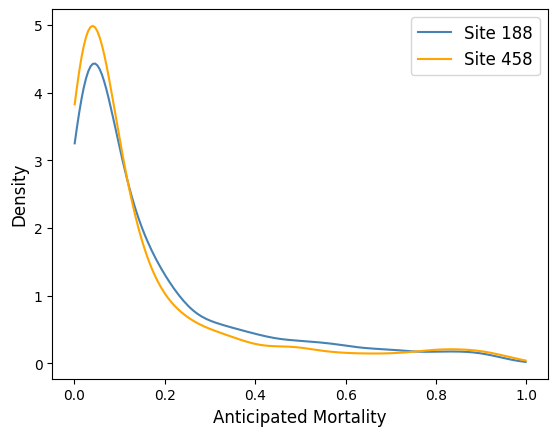

In [8]:
X_train=np.array(X_188)
X_test=np.array(X_458)
from scipy.stats import gaussian_kde
y_train=np.array(y_188)
y_test=np.array(y_458)

import seaborn as sns
x_train = X_train[:, 26]
y_train = X_train[:, 27]
x_test = X_test[:, 26]
y_test = X_test[:, 27]


x_train=x_train[x_train>-1]
y_train=y_train[y_train>-1]
x_test=x_test[x_test>-1]
y_test=y_test[y_test>-1]

# sns.kdeplot(x_train, label='Site 188', color='steelblue', fill=False)
# sns.kdeplot(x_test, label='Site 458', color='orange', fill=False)

# 估计密度
kde_train = gaussian_kde(x_train)
kde_test = gaussian_kde(x_test)

# 定义绘图范围
x_grid = np.linspace(
    min(np.min(x_train), np.min(x_test)),
    max(np.max(x_train), np.max(x_test)),
    200
)
plt.plot(x_grid, kde_train(x_grid), label='Site 188', color='steelblue')
plt.plot(x_grid, kde_test(x_grid), label='Site 458', color='orange')
plt.legend(fontsize=12)
plt.xlabel('Anticipated Mortality',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.savefig(f'distirbution_diff.pdf',bbox_inches='tight')

# plt.hist(y_train, bins=20, alpha=0.5, label='Train', color='steelblue',density=True)
# plt.hist(y_test, bins=20, alpha=0.5, label='Test', color='orange',density=True)